# 05 - Functions: Heat Transfer
A common equation used in heat transfer is the empirical relation relating the convective heat transfer coefficient to the temperature difference between the object and the fluid to yield the amount of heat transferred. This equation is called Newton's Law of Cooling and is given by:

$$
\begin{equation}
\dot{Q} = h A_s (T_s - T_\infty)
\end{equation}
$$

where $\dot{Q}$ is the heat transfer rate, $h$ is the convective heat transfer coefficient, $A_s$ is the surface area of the object, $T_s$ is the surface temperature of the object, and $T_\infty$ is the temperature of the fluid.

### Function Properties First

Prior to getting to our example, lets first show how variables within a function are not shared outside of the function. This is a key concept in programming and is known as variable scope.

In [10]:
x = 5 #setting a variable x = 5. This is a global variable as it is outside of any function or class. 
# I can use this variable anywhere in the code, including inside a function or class.

def afunction(input):
    newval = input + x #using the x global variable inside the function.
    x = 10 #setting a new value for x. This will yield an error.
    return newval

print(f'The afunction value with an input of 43 is {afunction(43)}. The global x value is still {x}.')

UnboundLocalError: local variable 'x' referenced before assignment

In [11]:
#Similarly, a function value can't be used outside of the function.

def anotherfunction(input):
    avariable = 10
    newval = input + avariable
    return newval

print(f'The anotherfunction value with an input of 43 is {anotherfunction(43)}. The avariable value is {avariable} not available outside of the function.')

NameError: name 'avariable' is not defined

## Example: External flow across a cylinder in crossflow
Suppose we have a heated rod with a fan blowing air across it. We'll first estimate the heat transfer coefficient and then the total heat lost given some details about the scenario.

<img src="https://github.com/clint-bg/comptools/blob/main/lectures/supportfiles/crossflowcyl.png?raw=true" width='350'>

The heat transfer coefficient is often put in terms of the Nusselt number, $Nu$, which is defined as:

$$
\begin{equation}
Nu = \frac{h D}{k} 
\end{equation}
$$

where $D$ is a characteristic length, $k$ is the thermal conductivity of the fluid, and $h$ is the convective heat transfer coefficient. The Nusselt number is a dimensionless number that is often correlated with the Reynolds number, $Re$, and the Prandtl number, $Pr$, to yield the following equation for a rod in crossflow as reported on Page 210 of the NCEES FE Handbook:

$$
Nu = C Re^n Pr^{1/3}
$$
    
where $C$, and $n$ are constants (given below for external flow of a cylinder in crossflow per Page 210 of the NCEES FE Handbook), $Re$ is the Reynolds number, and $Pr$ is the Prandtl number.


|Re| $C$ | $n$ |
|---|---|---|
|1 – 4| 0.989 |0.330|
|4 – 40 |0.911| 0.385|
|40 – 4,000| 0.683| 0.466|
|4,000 – 40,000| 0.193| 0.618|
|40,000 – 250,000| 0.0266 |0.805|

### Method 1: Using Objects and Functions
Plot the heat lost from a rod as a function of the air velocity.

In [1]:
#first define our medium properties (or air that is impinging on the cylinder)
import param #import our param module
class medium(param.Parameterized): #set default values for air at 20C
    k = param.Number(default=0.026, doc="Thermal conductivity of the medium (W/mK)")
    rho = param.Number(default=1.204, doc="Density of the medium (kg/m^3)")
    cp = param.Number(default=1006.0, doc="Specific heat of the medium (J/kgK)")
    mu = param.Number(default=1.82e-5, doc="Dynamic viscosity of the medium (kg/ms)")

    #Define function for the Reynolds number and Prandtl numbers
    # see pages 209 and 210 in the NCESS FE Handbook
    def Re(self, v, D):
        return self.rho*v*D/self.mu
    def Pr(self):
        return self.mu*self.cp/self.k
    def Nu_crossflowCyl(self, v, D):
        ReN = self.Re(v,D)
        if ReN<4:
            C = 0.989; n = 0.330
        elif ReN<40:
            C = 0.911; n = 0.385
        elif ReN<4000:
            C = 0.683; n = 0.466
        elif ReN<40000:
            C = 0.193; n = 0.618
        else:
            C = 0.0266; n = 0.805
        return C*ReN**n*self.Pr()**(1/3)
# set air object
air = medium()

```{note}
The above code doesn't have any global variables other than the air object. If you don't call the medium class, you can't access k, rho or any of the other variables or the Re or Pr methods. 
```

In [2]:
#we'll define a function to calculate the heat transfer from a hot surface in a forced 
#convection environment.  
def Qconv(vel=1,Dia=1,As=0.1, T_s=300, T_inf=298): #set defaults in SI units
    # calculate the heat transfer coefficient
    h = air.Nu_crossflowCyl(vel,Dia)/Dia*air.k #1/m * W/m/K = W/m^2/K
    return h*As*(T_s - T_inf) #convected heat transfer, W = W/m^2/K * m^2 * K

Now that we have our object and functions defined, lets plot the heat loss as a function of the air velocity assuming 20C air and a 100C surface temperature of }the 0.1m diameter and 1 foot long rod.

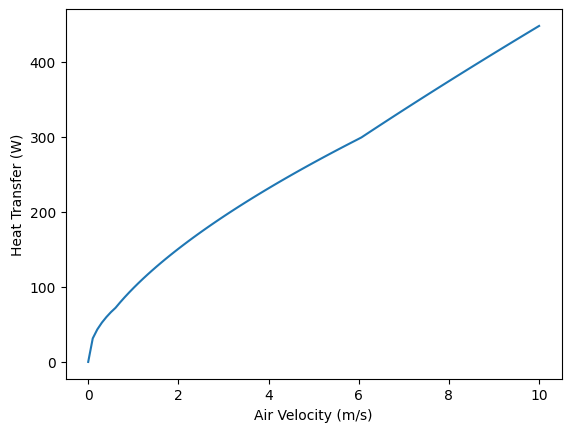

In [3]:
import numpy as np #import numpy for array operations
import matplotlib.pyplot as plt #import matplotlib for plotting
#set up a range of velocities
vel = np.linspace(0,10,100) #m/s
#set up the rod properties
rodDia = 0.1 #m
rodLength = 1/3.281 #foot to meter
rodArea = np.pi*rodDia*rodLength #m^2
#calculate the heat transfer for each velocity
Q = [Qconv(each,rodDia,rodArea, 393, 293) for each in vel]
#plot the results
plt.plot(vel,Q)
plt.xlabel('Air Velocity (m/s)'); plt.ylabel('Heat Transfer (W)')
plt.show()

### Method 2: Not using Objects
Some may say 
> "I don't want to use objects. I also don't want to use a lot of functions. I know I need one for the Nusselt number correlation so I'll start with that first. Otherwise I'll just type everything in."

In [4]:
def Nu(Re, Pr):
    if Re<4:
        C = 0.989; n = 0.330
    elif Re<40:
        C = 0.911; n = 0.385
    elif Re<4000:
        C = 0.683; n = 0.466
    elif Re<40000:
        C = 0.193; n = 0.618
    else:
        C = 0.0266; n = 0.805
    return C*Re**n*Pr**(1/3)

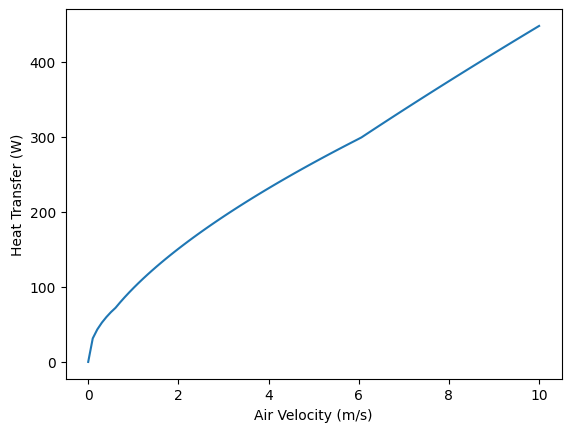

In [5]:
#setup up the air properties
air_k = 0.026 #W/mK
air_rho = 1.204 #kg/m^3
air_cp = 1006.0 #J/kgK
air_mu = 1.82e-5 #kg/ms
#setup the rod properties
rodDia = 0.1 #m
rodLength = 1/3.281 #foot to meter
rodArea = np.pi*rodDia*rodLength #m^2
#now calculate the heat transfer for each velocity
Q = []
vel = np.linspace(0,10,100) #m/s
for each in vel:
    Re = air_rho*each*rodDia/air_mu
    Pr = air_mu*air_cp/air_k
    h = Nu(Re,Pr)*air_k/rodDia
    Q.append(h*rodArea*(393-293))
#plot the results
plt.plot(vel,Q)
plt.xlabel('Air Velocity (m/s)'); plt.ylabel('Heat Transfer (W)')
plt.show()

Method 2 appears to be simpler and more straight forward. However, there are advantages for using objects and embedded functions:
- One common mistake is to use the wrong property data when calculating the Prandtl or Reynolds numbers. For example, using the thermal conductivity of the rod instead of the air when calculating the heat transfer coefficient. Including the Reynolds number and Prandtl number in the air object ensures that the correct property data is used.
- If you were to do this for a more complicated problem, you would have to type in the same equations over and over again. This is where objects and functions can be very useful.
- As the lines of code increase, it becomes more difficult to keep track of all the variables. Objects and functions make that easier and more succinct.
- Professional programs are written using objects and functions. It is good practice to learn how to use them.